# Baseline: Classical Autoencoder
A classical benchmark for the quantum enhanced autoencoder, following the structure given in "Applying Quantum Autoencoders for Time Series Anomaly Detection", published 10/10/2024, by Robin Frehner, Kurt Stockinger.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Paths to your dataset
train_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TRAIN.tsv'
test_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TEST.tsv'

In [5]:
# Load the data
def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None)
    data = data.iloc[:, 1:]  # Remove the first useless column
    return data.values

train_data = load_data(train_file_path)
test_data = load_data(test_file_path)

# Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [9]:
train_data.shape

(175, 463)

In [25]:
# PyTorch Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0)

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [26]:
class Autoencoder(nn.Module):
    def __init__(self, window_size, input_size):
        super(Autoencoder, self).__init__()
        self.encoder_lstm = nn.LSTM(input_size=input_size, hidden_size=window_size, batch_first=True)
        self.encoder_fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(window_size, 10),
            nn.ReLU(),
            nn.Linear(10, 4)
        )
        self.decoder_fc = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, window_size),
            nn.ReLU()
        )
        self.decoder_lstm = nn.LSTM(input_size=window_size, hidden_size=input_size, batch_first=True)


    def forward(self, x):
        # Encoding: Pass through the encoder layers
        outputs, (h_n, c_n) = self.encoder_lstm(x)  # Pass through LSTM layer, get output and hidden states
        encoded = self.encoder_fc(outputs[:, -1, :])  # Pass the last output of the LSTM through the fully connected layers

        # Decoding: Repeat latent representation and pass through decoder layers
        decoded = encoded.unsqueeze(1).repeat(1, x.shape[1], 1) # Repeat the latent vector to match input sequence length
        decoded, _ = self.decoder_lstm(self.decoder_fc(decoded))  # Pass through decoder layers

        return decoded


In [28]:
# Initialize model, loss, and optimizer

model = Autoencoder(window_size=128, input_size=train_data.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# Train the autoencoder
train_model(model, train_loader, criterion, optimizer)

Epoch 1/50, Loss: 0.0687
Epoch 2/50, Loss: 0.0318
Epoch 3/50, Loss: 0.0315
Epoch 4/50, Loss: 0.0255
Epoch 5/50, Loss: 0.0189
Epoch 6/50, Loss: 0.0175
Epoch 7/50, Loss: 0.0171
Epoch 8/50, Loss: 0.0169
Epoch 9/50, Loss: 0.0166
Epoch 10/50, Loss: 0.0168
Epoch 11/50, Loss: 0.0165
Epoch 12/50, Loss: 0.0164
Epoch 13/50, Loss: 0.0163
Epoch 14/50, Loss: 0.0164
Epoch 15/50, Loss: 0.0160
Epoch 16/50, Loss: 0.0162
Epoch 17/50, Loss: 0.0161
Epoch 18/50, Loss: 0.0161
Epoch 19/50, Loss: 0.0159
Epoch 20/50, Loss: 0.0157
Epoch 21/50, Loss: 0.0156
Epoch 22/50, Loss: 0.0149
Epoch 23/50, Loss: 0.0137
Epoch 24/50, Loss: 0.0133
Epoch 25/50, Loss: 0.0127
Epoch 26/50, Loss: 0.0127
Epoch 27/50, Loss: 0.0125
Epoch 28/50, Loss: 0.0123
Epoch 29/50, Loss: 0.0122
Epoch 30/50, Loss: 0.0120
Epoch 31/50, Loss: 0.0120
Epoch 32/50, Loss: 0.0117
Epoch 33/50, Loss: 0.0118
Epoch 34/50, Loss: 0.0117
Epoch 35/50, Loss: 0.0117
Epoch 36/50, Loss: 0.0115
Epoch 37/50, Loss: 0.0114
Epoch 38/50, Loss: 0.0113
Epoch 39/50, Loss: 0.

In [37]:
# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    reconstruction_losses = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            reconstruction_losses.append(loss.item())
    return np.array(reconstruction_losses)

reconstruction_losses = evaluate_model(model, test_loader)

In [40]:
# Define a threshold for anomalies
threshold = np.percentile(reconstruction_losses, 99)

# Identify anomalies
anomalies = reconstruction_losses > threshold

# Save results
results = pd.DataFrame({
    'Reconstruction Loss': reconstruction_losses,
    'Anomaly': anomalies
})
results.to_csv('/content/drive/My Drive/anomaly_results.csv', index=False)

print("Threshold for anomalies:", threshold)
print("Anomalies detected:", np.sum(anomalies))

Threshold for anomalies: 0.047464076578617065
Anomalies detected: 2


In [42]:
# Get the indices of the anomalous time series
anomalous_indices = results[results['Anomaly'] == True].index.tolist()

# Print the anomalous indices
print("Anomalous Time Series Indices:", anomalous_indices)

Anomalous Time Series Indices: [89, 161]


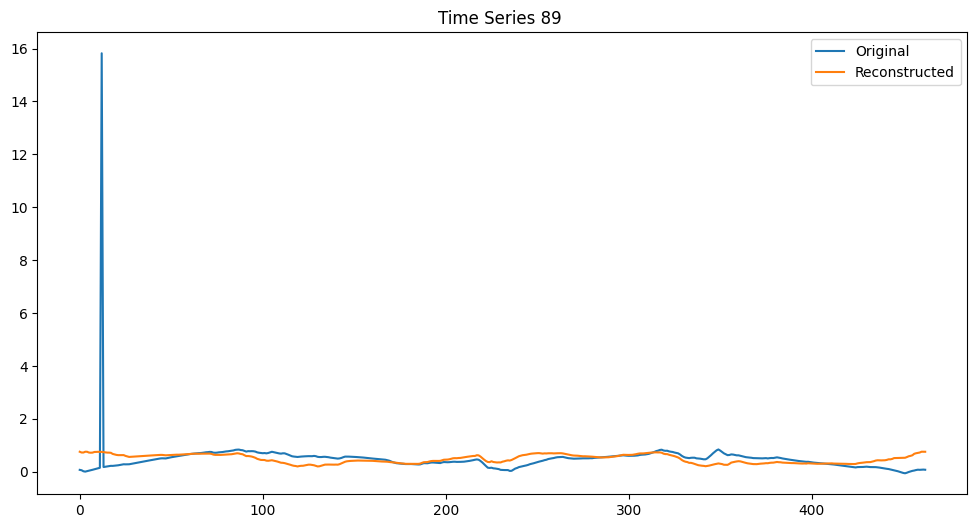

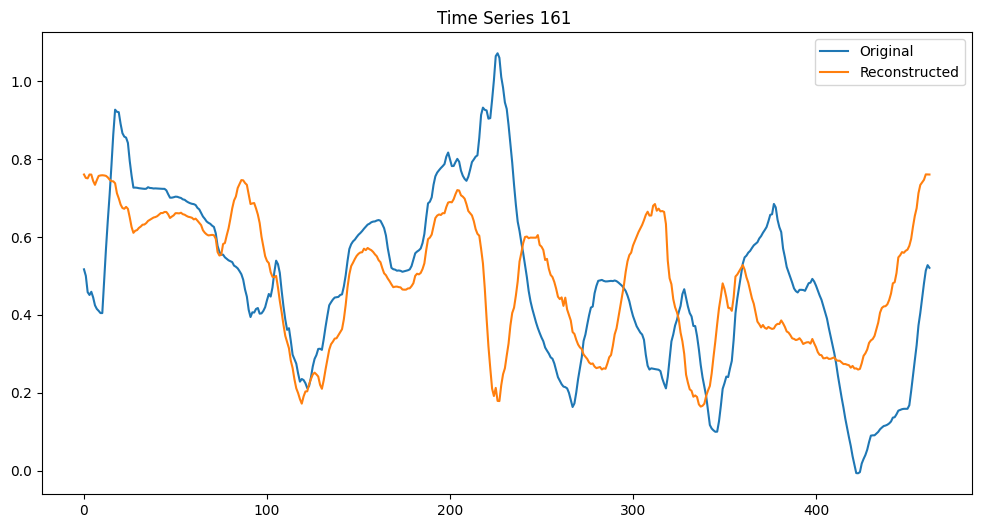

In [47]:
import matplotlib.pyplot as plt

# Plot anomalous time series with reconstructions
for index in anomalous_indices:
    original_time_series = test_dataset[index]  # Get original time series data

    # Reshape and convert to tensor
    original_time_series_reshaped = original_time_series.unsqueeze(0)  # Add batch dimension

    # Get model output for the time series
    with torch.no_grad():
        reconstructed_time_series = model(original_time_series_reshaped)

    # Convert to numpy and reshape for plotting
    original_time_series = original_time_series.numpy().reshape(-1)
    reconstructed_time_series = reconstructed_time_series.numpy().reshape(-1)

    # Create a new figure for each plot
    plt.figure(figsize=(12, 6))

    # Plot the original and reconstructed time series
    plt.plot(original_time_series, label='Original')
    plt.plot(reconstructed_time_series, label='Reconstructed')
    plt.title(f'Time Series {index} ')
    plt.legend()
    plt.show()

This autoencoder model provided in the article proved to be able to detect the one and only anomalous time series  in the dataset, which is clearly time series 89, with its anomalous spike.

Time series 161 is just the worst encoded non-anomalous time series: it has a relatively high reconstruction loss, so it falls above the 99th percentile. If we should set the anomaly threshold to the  99.9th percentile, it would fall below.